In [3]:
import pandas as pd
pd.options.display.float_format = '{:,.4f}'.format
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, classification_report, log_loss
from scipy.stats import ks_2samp

In [4]:
acctDF = pd.read_parquet('../../data/q2-ucsd-acctDF.pqt')
acctDF['balance_date'] = pd.to_datetime(acctDF['balance_date'])

consDF_all = pd.read_parquet('../../data/q2-ucsd-consDF.pqt')

consDF = consDF_all.dropna()
trxnDF = pd.read_parquet('../../data/q2-ucsd-trxnDF.pqt')
trxnDF['posted_date'] = pd.to_datetime(trxnDF['posted_date'])

cat_map = pd.read_csv('../../data/q2-ucsd-cat-map.csv')


In [5]:
display(acctDF), display(consDF), display(trxnDF)

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
0,3023,0,SAVINGS,2021-08-31,90.5700
1,3023,1,CHECKING,2021-08-31,225.9500
2,4416,2,SAVINGS,2022-03-31,"15,157.1700"
3,4416,3,CHECKING,2022-03-31,66.4200
4,4227,4,CHECKING,2021-07-31,"7,042.9000"
...,...,...,...,...,...
24461,11500,24461,CHECKING,2022-03-27,732.7500
24462,11615,24462,SAVINGS,2022-03-30,5.0000
24463,11615,24463,CHECKING,2022-03-30,"1,956.4600"
24464,12210,24464,CHECKING,2022-03-28,"2,701.5100"


,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET
0,0,2021-09-01,726.0000,0.0000
1,1,2021-07-01,626.0000,0.0000
2,2,2021-05-01,680.0000,0.0000
3,3,2021-03-01,734.0000,0.0000
4,4,2021-10-01,676.0000,0.0000
...,...,...,...,...
13995,13995,2022-01-22,802.0000,0.0000
13996,13996,2022-02-01,652.0000,0.0000
13997,13997,2021-12-24,765.0000,0.0000
13998,13998,2022-01-30,685.0000,0.0000


,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,4,0.0500,CREDIT,2021-04-16
1,3023,1,12,481.5600,CREDIT,2021-04-30
2,3023,2,4,0.0500,CREDIT,2021-05-16
3,3023,3,4,0.0700,CREDIT,2021-06-16
4,3023,4,4,0.0600,CREDIT,2021-07-16
...,...,...,...,...,...,...
6407316,10533,6405304,31,4.9600,DEBIT,2022-03-11
6407317,10533,6405305,12,63.4800,DEBIT,2022-03-30
6407318,10533,6405306,12,53.9900,DEBIT,2022-03-30
6407319,10533,6405307,12,175.9800,DEBIT,2022-03-31


(None, None, None)

In [6]:
acctConsDF = consDF.merge(acctDF, how='left', on='prism_consumer_id',)
acctConsDF.head()

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,prism_account_id,account_type,balance_date,balance
0,0,2021-09-01,726.0000,0.0000,862,SAVINGS,2021-08-31,25.7000
1,0,2021-09-01,726.0000,0.0000,863,CHECKING,2021-08-31,294.6700
2,1,2021-07-01,626.0000,0.0000,7754,SAVINGS,2021-06-30,"3,211.1800"
3,1,2021-07-01,626.0000,0.0000,7755,CHECKING,2021-06-30,91.2400
4,2,2021-05-01,680.0000,0.0000,4666,SAVINGS,2021-04-30,"2,561.4300"


# Week 1 - Best Single Feature

### Test Predictability w/ Logistic Regression Model

In [7]:
def lr_best_single(X, y):
    """
    Trains a logistic regression model on the provided data, evaluates its performance, 
    and returns key metrics.

    Parameters:
    ----------
    X : array-like or DataFrame
        Feature matrix containing predictor variables.
    y : array-like or Series
        Target variable (binary classification).

    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = LogisticRegression()
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Compute R^2
    # ll_model = -log_loss(y, model.predict_proba(X), normalize=False)
    # ll_null = -log_loss(y, [y.mean()] * len(y), normalize=False)
    # r2 = 1 - (ll_model / ll_null)

    r = np.corrcoef(y.squeeze(), X.squeeze())[0][1]
    r2 = (r) ** 2
    

    roc_auc = roc_auc_score(y_test, y_pred_proba)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"r^2 value: {r2:.4f}")
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    return accuracy, roc_auc, confusion_matrix, classification_report(y_test, y_pred)


In [8]:
def ks_test(data, ftr='credit_score', target='DQ_TARGET'):
    """
    Performs the Kolmogorov-Smirnov (KS) test to compare the distributions 
    of two samples and returns the KS statistic and p-value.

    Parameters:
    ----------
    ftr_0 : array-like
        Sample values for the first group (e.g., feature values for class 0).
    ftr_1 : array-like
        Sample values for the second group (e.g., feature values for class 1).

    Returns:
    -------
    ks_stat : float
        The KS statistic, representing the maximum difference between the two cumulative distributions.
    p_value : float
        The p-value indicating the significance of the difference between the distributions.


    Notes:
    ------

    If the P value is small, conclude that the two groups were sampled from populations with different distributions. 
    The populations may differ in median, variability or the shape of the distribution.

    """
    
    ftr_0 = data[data[target] == 0][ftr]
    ftr_1 = data[data[target] == 1][ftr]
    ks_stat, p_value = ks_2samp(ftr_0, ftr_1)

    print(f"KS_stat  = {ks_stat}")
    print(f"p value = {p_value}")

    plt.figure(figsize=(8, 6))
    plt.hist(ftr_0, bins=30, alpha=0.5, label=ftr+"_0", density=True)
    plt.hist(ftr_1, bins=30, alpha=0.5, label=ftr+"_1", density=True)
    plt.title("Feature Distribution by Class")
    plt.xlabel("Feature Value")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

    
    return ks_stat, p_value


### Credit Score - DQ_TARGET

In [9]:
credit_scoreDF = consDF[['credit_score', 'DQ_TARGET']]
credit_scoreDF.head()

,credit_score,DQ_TARGET
0,726.0000,0.0000
1,626.0000,0.0000
2,680.0000,0.0000
3,734.0000,0.0000
4,676.0000,0.0000


In [10]:
corr_credit_score = consDF['credit_score'].corr(consDF.DQ_TARGET)
corr_credit_score

-0.2613083627746771

In [11]:
cs_X = consDF[['credit_score']]
y = consDF[['DQ_TARGET']]

accuracy, roc_auc, confusion_matrix, cr = lr_best_single(cs_X, y)

ROC AUC Score: 0.7497
Accuracy: 0.9125
r^2 value: 0.0683

Confusion Matrix:
[[2187    5]
 [ 205    3]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.91      1.00      0.95      2192
         1.0       0.38      0.01      0.03       208

    accuracy                           0.91      2400
   macro avg       0.64      0.51      0.49      2400
weighted avg       0.87      0.91      0.87      2400



/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KS_stat  = 0.3881249523054506
p value = 1.4927461734165962e-125


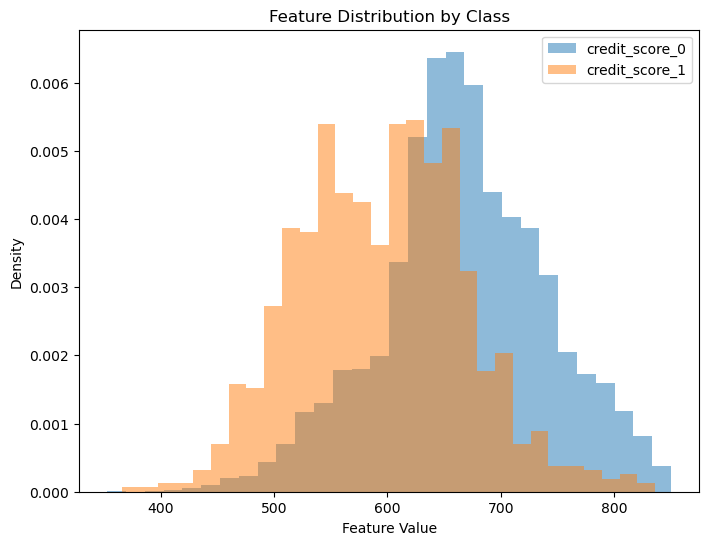

(0.3881249523054506, 1.4927461734165962e-125)

In [12]:
ks_test(consDF, ftr='credit_score', target='DQ_TARGET')

### Credit / Debit - DQ Target

In [13]:
trxnDF_prc = trxnDF.copy()
trxnDF_prc['cd_num'] = trxnDF_prc.credit_or_debit.apply(lambda x: 1 if x == 'CREDIT' else -1)
trxnDF_prc = trxnDF_prc.groupby('prism_consumer_id')['cd_num'].sum().reset_index()

trxnDF_prc.head()

,prism_consumer_id,cd_num
0,0,-332
1,1,-172
2,10,-171
3,100,-22
4,1000,-81


In [14]:
consTrxnDF = consDF.merge(trxnDF_prc, how='inner', on='prism_consumer_id',)

consTrxnDF.head()

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET,cd_num
0,0,2021-09-01,726.0000,0.0000,-332
1,1,2021-07-01,626.0000,0.0000,-172
2,2,2021-05-01,680.0000,0.0000,-286
3,3,2021-03-01,734.0000,0.0000,-169
4,4,2021-10-01,676.0000,0.0000,-226


In [15]:
corr_cd = consTrxnDF.cd_num.corr(consTrxnDF.DQ_TARGET)
corr_cd

0.034963946187154316

In [16]:
cd_X = consTrxnDF[['cd_num']]
y = consTrxnDF[['DQ_TARGET']]
accuracy, roc_auc, confusion_matrix, cr = lr_best_single(cd_X, y)

ROC AUC Score: 0.5622
Accuracy: 0.9207
r^2 value: 0.0012

Confusion Matrix:
[[2137    0]
 [ 184    0]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96      2137
         1.0       0.00      0.00      0.00       184

    accuracy                           0.92      2321
   macro avg       0.46      0.50      0.48      2321
weighted avg       0.85      0.92      0.88      2321



/opt/conda/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning

KS_stat  = 0.10349583584347188
p value = 1.4126770198758131e-08


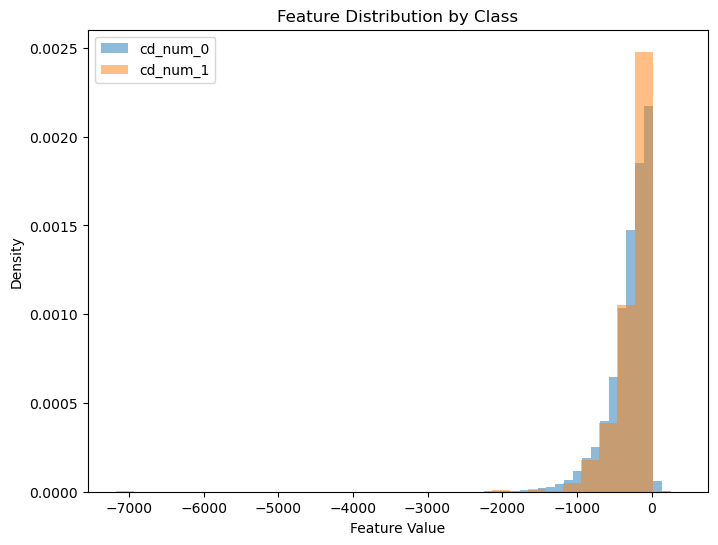

(0.10349583584347188, 1.4126770198758131e-08)

In [17]:
ks_test(consTrxnDF, ftr='cd_num', target='DQ_TARGET')

# Week 2 - Balance / Income Ftrs

### Balances over time

In [18]:
display(consDF.head()), display(acctDF)

,prism_consumer_id,evaluation_date,credit_score,DQ_TARGET
0,0,2021-09-01,726.0000,0.0000
1,1,2021-07-01,626.0000,0.0000
2,2,2021-05-01,680.0000,0.0000
3,3,2021-03-01,734.0000,0.0000
4,4,2021-10-01,676.0000,0.0000


,prism_consumer_id,prism_account_id,account_type,balance_date,balance
0,3023,0,SAVINGS,2021-08-31,90.5700
1,3023,1,CHECKING,2021-08-31,225.9500
2,4416,2,SAVINGS,2022-03-31,"15,157.1700"
3,4416,3,CHECKING,2022-03-31,66.4200
4,4227,4,CHECKING,2021-07-31,"7,042.9000"
...,...,...,...,...,...
24461,11500,24461,CHECKING,2022-03-27,732.7500
24462,11615,24462,SAVINGS,2022-03-30,5.0000
24463,11615,24463,CHECKING,2022-03-30,"1,956.4600"
24464,12210,24464,CHECKING,2022-03-28,"2,701.5100"


(None, None)

In [19]:
good = consDF[consDF['DQ_TARGET'] == 0].sample(n=3).prism_consumer_id.values
bad = consDF[consDF['DQ_TARGET'] == 1].sample(n=3).prism_consumer_id.values

good, bad

(array(['3695', '2139', '11750'], dtype=object),
 array(['8148', '5411', '6486'], dtype=object))

In [20]:
def plot_good_bad(ids=None):
    if not ids:
        good = consDF[consDF['DQ_TARGET'] == 0].sample(n=3).prism_consumer_id.values
        bad = consDF[consDF['DQ_TARGET'] == 1].sample(n=3).prism_consumer_id.values
    else:
        good = ids[:len(ids)//2]
        bad = ids[len(ids)//2:]

    good_colors = cm.Greens([0.4, 0.6, 0.8])  # Three shades of green
    bad_colors = cm.Reds([0.4, 0.6, 0.8])     # Three shades of red


    for i, cid in enumerate(good):
        data = acctDF[acctDF['prism_consumer_id'] == cid]
        plt.plot(
            data['balance_date'], 
            data['balance'], 
            marker='o', 
            label=f'Good Consumer {cid}',
            color=good_colors[i % len(good_colors)]  # Cycle through green shades
        )
    
    # Plot bad consumers
    for i, cid in enumerate(bad):
        data = acctDF[acctDF['prism_consumer_id'] == cid]
        plt.plot(
            data['balance_date'], 
            data['balance'], 
            marker='o', 
            label=f'Bad Consumer {cid}',
            color=bad_colors[i % len(bad_colors)]  # Cycle through red shades
        )


    plt.title('Balance Over Time')
    plt.xlabel('Date')
    plt.ylabel('Balance')
    plt.grid(True)
    plt.legend(title='Consumer ID')
    plt.tight_layout()
    plt.show()



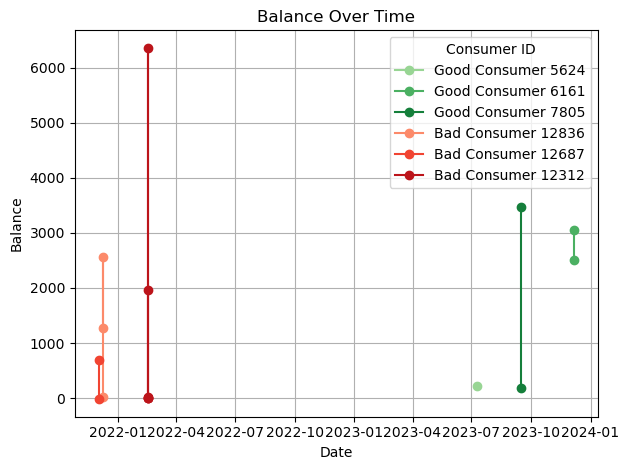

In [21]:
plot_good_bad()

In [22]:
acctDF[acctDF.prism_consumer_id == '5837']

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
16347,5837,16347,CHECKING,2023-08-06,222.3300


In [23]:
trxnDF[trxnDF.prism_consumer_id == '5837'].sort_values(by='posted_date')

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
2816935,5837,2814923,3,"1,905.3900",CREDIT,2023-05-10
2817053,5837,2815041,35,104.9900,DEBIT,2023-05-10
2817052,5837,2815040,35,44.2500,DEBIT,2023-05-10
2817051,5837,2815039,35,21.9300,DEBIT,2023-05-10
2817050,5837,2815038,1,18.3800,DEBIT,2023-05-10
...,...,...,...,...,...,...
2817531,5837,2815519,17,5.8600,DEBIT,2023-08-05
2817537,5837,2815525,21,15.1600,DEBIT,2023-08-06
2817538,5837,2815526,16,25.0000,DEBIT,2023-08-06
2817539,5837,2815527,14,2.9500,DEBIT,2023-08-07


In [24]:
def plot_incomes(cids=None, year=None):
    if year:
        temp = acctDF[acctDF.balance_date.dt.year == 2023]
    else:
        temp = acctDF.copy()
    if not cids:
        temp = temp.groupby('prism_consumer_id').count()
        temp = temp[temp['balance_date'] >= 5]
        cids = temp.reset_index().prism_consumer_id.sample(n=3).values

    colors = cm.tab10.colors
    plt.figure(figsize=(16, 8))

    for i, cid in enumerate(cids):
        data = acctDF[acctDF['prism_consumer_id'] == cid]
        plt.plot(
            data['balance_date'], 
            data['balance'], 
            marker='o', 
            label=f'Consumer {cid}',
            color=colors[i % len(colors)] 
        )
  
    plt.title('Balance Over Time for Multiple Consumers')
    plt.xlabel('Date')
    plt.ylabel('Balance')
    plt.grid(True)
    plt.legend(title='Consumer ID')
    plt.tight_layout()
    plt.show()


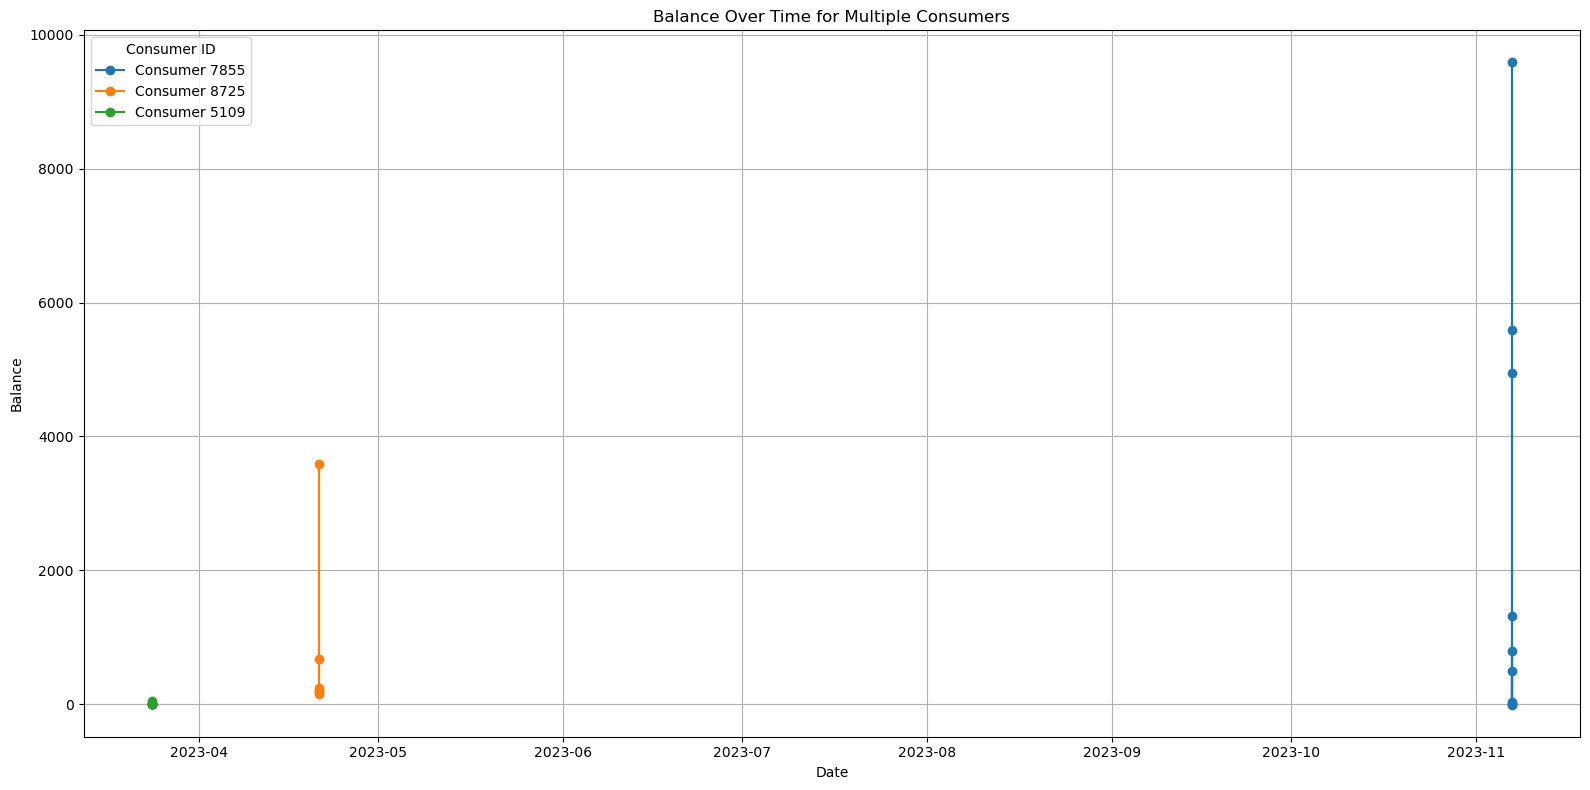

In [25]:
plot_incomes(year=2023)

In [26]:
acctDF.head()

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
0,3023,0,SAVINGS,2021-08-31,90.5700
1,3023,1,CHECKING,2021-08-31,225.9500
2,4416,2,SAVINGS,2022-03-31,"15,157.1700"
3,4416,3,CHECKING,2022-03-31,66.4200
4,4227,4,CHECKING,2021-07-31,"7,042.9000"


### Running Balance 

In [40]:
x = acctDF[acctDF.account_type == 'CHECKING']
x = x[x.prism_consumer_id == '7855']

x

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
16566,7855,16566,CHECKING,2023-11-07,"5,588.5800"
16568,7855,16568,CHECKING,2023-11-07,"1,324.3100"
16569,7855,16569,CHECKING,2023-11-07,0.4000
16570,7855,16570,CHECKING,2023-11-07,499.6400


In [54]:
check_acct_totals = acctDF[acctDF.account_type == 'CHECKING'].groupby(['prism_consumer_id', 'balance_date']).sum()
check_acct_totals = check_acct_totals.reset_index()
check_acct_totals = check_acct_totals.drop(axis=1,labels='prism_account_id')
check_acct_totals.head()

,prism_consumer_id,balance_date,account_type,balance
0,0,2021-08-31,CHECKING,294.6700
1,1,2021-06-30,CHECKING,91.2400
2,10,2022-01-31,CHECKING,822.7500
3,100,2021-04-30,CHECKING,802.4000
4,1000,2023-01-31,CHECKING,95.2300


In [55]:
balanceDF = trxnDF.copy()
balanceDF.head()

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,4,0.0500,CREDIT,2021-04-16
1,3023,1,12,481.5600,CREDIT,2021-04-30
2,3023,2,4,0.0500,CREDIT,2021-05-16
3,3023,3,4,0.0700,CREDIT,2021-06-16
4,3023,4,4,0.0600,CREDIT,2021-07-16


In [59]:
t1 = check_acct_totals[check_acct_totals.prism_consumer_id == '3023']
t1

,prism_consumer_id,balance_date,account_type,balance
5395,3023,2021-08-31,CHECKING,225.9500


In [58]:
t2 = balanceDF[balanceDF.prism_consumer_id == '3023']
t2

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
0,3023,0,4,0.0500,CREDIT,2021-04-16
1,3023,1,12,481.5600,CREDIT,2021-04-30
2,3023,2,4,0.0500,CREDIT,2021-05-16
3,3023,3,4,0.0700,CREDIT,2021-06-16
4,3023,4,4,0.0600,CREDIT,2021-07-16
...,...,...,...,...,...,...
200,3023,200,39,10.9100,DEBIT,2021-09-17
201,3023,201,4,81.7300,DEBIT,2021-09-18
202,3023,202,16,21.8500,DEBIT,2021-09-20
203,3023,203,45,25.0000,DEBIT,2021-09-20


In [107]:
tbd = t1.balance_date.values[0]
orig_balance = t1.balance.values[0]
curr_balance = orig_balance
pre_balances = [orig_balance]
post_balances = []

print(tbd, curr_balance)
t3 = t2[t2.posted_date <= tbd].sort_values(by='posted_date', ascending=False)
t5 = t2[t2.posted_date > tbd].sort_values(by='posted_date', ascending=True)
t3

2021-08-31T00:00:00.000000000 225.95


,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date
186,3023,186,45,40.0000,DEBIT,2021-08-31
185,3023,185,45,25.0000,DEBIT,2021-08-30
184,3023,184,45,25.0000,DEBIT,2021-08-30
183,3023,183,45,25.0000,DEBIT,2021-08-30
182,3023,182,45,25.0000,DEBIT,2021-08-30
...,...,...,...,...,...,...
48,3023,48,45,40.0000,DEBIT,2021-03-30
47,3023,47,45,25.0000,DEBIT,2021-03-29
8,3023,8,1,340.0000,CREDIT,2021-03-27
7,3023,7,1,240.0000,CREDIT,2021-03-27


In [108]:
for i, row in t3.iterrows(): #t3.iloc[1:].iterrows()
    if row.credit_or_debit == 'CREDIT':
        curr_balance -= row.amount
    else:
        curr_balance += row.amount
    pre_balances.append(curr_balance)

curr_balance = orig_balance
for i, row in t5.iterrows():
    if row.credit_or_debit == 'CREDIT':
        curr_balance += row.amount
    else:
        curr_balance -= row.amount
    post_balances.append(curr_balance)

In [110]:
t4 = t3.copy()

t4['curr_balance'] = pre_balances[:-1]
t4.head()

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,curr_balance
186,3023,186,45,40.0000,DEBIT,2021-08-31,225.9500
185,3023,185,45,25.0000,DEBIT,2021-08-30,265.9500
184,3023,184,45,25.0000,DEBIT,2021-08-30,290.9500
183,3023,183,45,25.0000,DEBIT,2021-08-30,315.9500
182,3023,182,45,25.0000,DEBIT,2021-08-30,340.9500


In [111]:
t6 = t5.copy()

t6['curr_balance'] = post_balances
t6.head()

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,curr_balance
187,3023,187,45,50.0000,DEBIT,2021-09-02,175.9500
37,3023,37,2,500.0000,CREDIT,2021-09-03,675.9500
38,3023,38,4,0.0900,CREDIT,2021-09-03,676.0400
188,3023,188,45,60.0000,DEBIT,2021-09-03,616.0400
189,3023,189,45,100.0000,DEBIT,2021-09-03,516.0400


In [115]:
pd.concat([t4, t6], axis=0)

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,curr_balance
186,3023,186,45,40.0000,DEBIT,2021-08-31,225.9500
185,3023,185,45,25.0000,DEBIT,2021-08-30,265.9500
184,3023,184,45,25.0000,DEBIT,2021-08-30,290.9500
183,3023,183,45,25.0000,DEBIT,2021-08-30,315.9500
182,3023,182,45,25.0000,DEBIT,2021-08-30,340.9500
...,...,...,...,...,...,...,...
201,3023,201,4,81.7300,DEBIT,2021-09-18,"1,027.6500"
40,3023,40,6,81.7300,CREDIT,2021-09-19,"1,109.3800"
202,3023,202,16,21.8500,DEBIT,2021-09-20,"1,087.5300"
203,3023,203,45,25.0000,DEBIT,2021-09-20,"1,062.5300"


In [120]:
def calc_balances_all(check_acct_totals, balanceDF):
    # takes too long -- will have to do for one consumer (or a couple consumers) at a time
    cids = check_acct_totals.prism_consumer_id.unique()
    to_concat = []

    for cid in cids:    
        t1 = check_acct_totals[check_acct_totals.prism_consumer_id == cid]
        t2 = balanceDF[balanceDF.prism_consumer_id == cid]

        tbd = t1.balance_date.values[0]
        orig_balance = t1.balance.values[0]
        curr_balance = orig_balance
        pre_balances = [orig_balance]
        post_balances = []
        
        preDF = t2[t2.posted_date <= tbd].sort_values(by='posted_date', ascending=False)
        postDF = t2[t2.posted_date > tbd].sort_values(by='posted_date', ascending=True)

        for i, row in preDF.iterrows():
            if row.credit_or_debit == 'CREDIT':
                curr_balance -= row.amount
            else:
                curr_balance += row.amount
            pre_balances.append(curr_balance)
        
        curr_balance = orig_balance
        for i, row in postDF.iterrows():
            if row.credit_or_debit == 'CREDIT':
                curr_balance += row.amount
            else:
                curr_balance -= row.amount
            post_balances.append(curr_balance)
            
        preDF['curr_balance'] = pre_balances[:-1]
        postDF['curr_balance'] = post_balances

        to_concat.append(pd.concat([preDF, postDF], axis=0))

    return pd.concat(to_concat, axis=0)

In [121]:
balances_all = calc_balances_all(check_acct_totals, balanceDF)
balances_all.head()

KeyboardInterrupt: 

In [91]:
# balanceDF = pd.merge(trxnDF, check_acct_totals, on='prism_consumer_id').dropna()
# balanceDF['before_balance_date'] = balanceDF.posted_date <= balanceDF.balance_date
# balanceDF = balanceDF.sort_values(['prism_consumer_id', 'before_balance_date', 'posted_date'], ascending=[True, False, False])

# balanceDF.replace(['', ' ', 'NaN', 'nan'], np.nan, inplace=True)
# balanceDF.dropna(axis=0, how='any', inplace=True)

# balanceDF.head()

In [28]:
def calculate_curr_balance(row, prev):
    print(row.amount, type(row.amount))
    print(prev, type(prev))
    if row.posted_date <= row.balance_date:
        if row.credit_or_debit == 'credit':
            return prev - row.amount
        else:
            return prev + row.amount
    else:
        if row.credit_or_debit == 'credit':
            return prev + row.amount
        else:
            return prev - row.amount

In [30]:
curr_balance = balanceDF.iloc[0]
balances = []

In [29]:
# for _, row in balanceDF.iterrows():
#     curr_balance = calculate_curr_balance(row, curr_balance)
#     balances.append(curr_balance)

In [ ]:
balanceDF['curr_balance'] = balances

In [31]:
balanceDF.head()

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,prism_account_id,account_type,balance_date,balance,before_balance_date
266324,0,136731,1,49.2500,CREDIT,2021-08-31,862,SAVINGS,2021-08-31,25.7000,True
266325,0,136731,1,49.2500,CREDIT,2021-08-31,863,CHECKING,2021-08-31,294.6700,True
267014,0,137076,16,72.4000,DEBIT,2021-08-31,862,SAVINGS,2021-08-31,25.7000,True
267015,0,137076,16,72.4000,DEBIT,2021-08-31,863,CHECKING,2021-08-31,294.6700,True
267016,0,137077,14,20.0000,DEBIT,2021-08-31,862,SAVINGS,2021-08-31,25.7000,True


In [33]:
balanceDF[balanceDF.prism_consumer_id == '7855']

,prism_consumer_id,prism_transaction_id,category,amount,credit_or_debit,posted_date,prism_account_id,account_type,balance_date,balance,before_balance_date
5379506,7855,2846886,1,85.1900,CREDIT,2023-11-07,16563,SAVINGS,2023-11-07,-3.9900,True
5379507,7855,2846886,1,85.1900,CREDIT,2023-11-07,16564,SAVINGS,2023-11-07,800.8300,True
5379508,7855,2846886,1,85.1900,CREDIT,2023-11-07,16565,SAVINGS,2023-11-07,31.1000,True
5379509,7855,2846886,1,85.1900,CREDIT,2023-11-07,16566,CHECKING,2023-11-07,"5,588.5800",True
5379510,7855,2846886,1,85.1900,CREDIT,2023-11-07,16567,SAVINGS,2023-11-07,"9,585.4200",True
...,...,...,...,...,...,...,...,...,...,...,...
5384761,7855,2847411,16,2.1100,DEBIT,2023-08-10,16568,CHECKING,2023-11-07,"1,324.3100",True
5384762,7855,2847411,16,2.1100,DEBIT,2023-08-10,16569,CHECKING,2023-11-07,0.4000,True
5384763,7855,2847411,16,2.1100,DEBIT,2023-08-10,16570,CHECKING,2023-11-07,499.6400,True
5384764,7855,2847411,16,2.1100,DEBIT,2023-08-10,16571,SAVINGS,2023-11-07,0.0500,True


In [34]:
acctDF[acctDF.prism_consumer_id == '7855']

,prism_consumer_id,prism_account_id,account_type,balance_date,balance
16563,7855,16563,SAVINGS,2023-11-07,-3.9900
16564,7855,16564,SAVINGS,2023-11-07,800.8300
16565,7855,16565,SAVINGS,2023-11-07,31.1000
16566,7855,16566,CHECKING,2023-11-07,"5,588.5800"
16567,7855,16567,SAVINGS,2023-11-07,"9,585.4200"
16568,7855,16568,CHECKING,2023-11-07,"1,324.3100"
16569,7855,16569,CHECKING,2023-11-07,0.4000
16570,7855,16570,CHECKING,2023-11-07,499.6400
16571,7855,16571,SAVINGS,2023-11-07,0.0500
16572,7855,16572,SAVINGS,2023-11-07,"4,945.7100"
